In [68]:
import pdb
import torch
import cv2
import os
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from torchvision.datasets.folder import pil_loader
import random
import numpy as np
from torchsummary import summary
from sklearn.model_selection import KFold, StratifiedKFold


from albumentations import torch as AT
os.environ['CUDA_VISIBLE_DEVICES']=""
%matplotlib inline

In [2]:
!ls data

sample_submission.csv  test  train  train_labels.csv


In [11]:
train_df = pd.read_csv('data/train_labels.csv')
test_df = pd.read_csv('data/sample_submission.csv')

In [12]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_df.at[0, 'label'] = 1

In [27]:
kfold = StratifiedKFold(20, shuffle=True, random_state=69)

In [36]:
kfold.split(train_df['id'], train_df['label'])

<generator object _BaseKFold.split at 0x7f93120189a8>

In [46]:
train_df.iloc[test]

,id,label
26,4e491f0beca3cc68b5013cbe726a9b358bf0f668,0
31,3fd6d45524adefa2b1210123b672fc84c9680f9e,0
64,0c9048efaa80ab8813fde3b649cfc54f02dabe56,1
72,9e4f48c0bbaf3beec183fc2892e07888952515c5,1
73,07f17b07fb6bb9639f96e5e78a8e04f287df9e84,0
74,729a7cfbcb7f50ecc89cb8661f0a80871c924d05,0
101,d155dd4f340d21a77a9bdb90455a67f5ce969e80,0
112,1bb23b52c53abdfb8105a5dda50bf6d5fa7b14fc,0
138,7c25a1131492328ca26c655dc7c75429e21c03f9,1
139,2d75ed4471e5f85662b4a14fbcca208b328f22a7,1


In [8]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,1
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [22]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
id       57458 non-null object
label    57458 non-null int64
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


(None, None)

In [23]:
%%time
img = mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

CPU times: user 4.72 ms, sys: 0 ns, total: 4.72 ms
Wall time: 4.12 ms


In [24]:
timeit mpimg.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

180 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
timeit pil_loader('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')

151 µs ± 2.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [182]:
timeit cv2.imread('data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', flags=cv2.IMREAD_COLOR)

46.4 µs ± 975 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [185]:
timeit io.imread("data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")

225 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


##### use cv2.imread for reading images 

In [8]:
img.shape


(96, 96, 3)

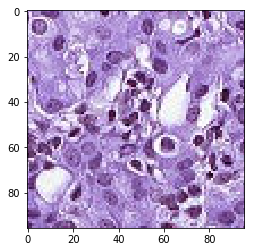

In [173]:
plt.imshow(img)

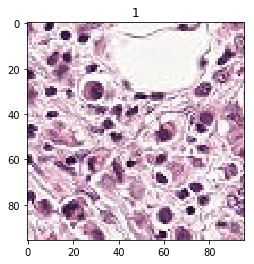

In [10]:
# plot some random training images with their ground truth labels
i = random.choice(range(train_df.shape[0]))
img = mpimg.imread('data/train/' + train_df.iloc[i]['id'] + '.tif')
plt.imshow(img)
plt.title(train_df.iloc[i]['label'])
plt.show()

In [11]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
train_df['label'].hist

<bound method hist_series of 0         0
1         1
2         0
3         0
4         0
5         0
6         1
7         1
8         0
9         0
10        0
11        1
12        0
13        0
14        1
15        0
16        0
17        1
18        0
19        1
20        0
21        0
22        0
23        1
24        1
25        0
26        0
27        0
28        1
29        1
         ..
219995    1
219996    0
219997    1
219998    1
219999    0
220000    0
220001    1
220002    1
220003    0
220004    0
220005    1
220006    0
220007    1
220008    0
220009    1
220010    1
220011    0
220012    1
220013    0
220014    1
220015    0
220016    0
220017    0
220018    0
220019    0
220020    0
220021    1
220022    0
220023    0
220024    1
Name: label, Length: 220025, dtype: int64>

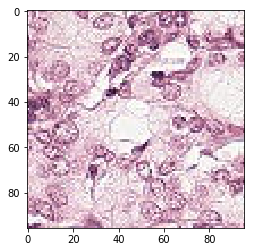

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


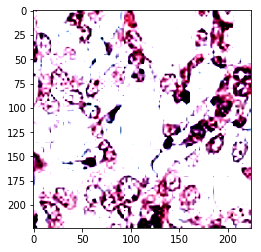

In [48]:
img = mpimg.imread('data/train/dd6dfed324f9fcb6f93f46f32fc800f2ec196be2.tif')
plt.imshow(img)
plt.show();
aug_img = train_aug(image=img)
plt.imshow(aug_img['image'])
plt.show();

#### Dataloader analysis


In [14]:
from dataloader import get_dataloader

In [197]:
def unnormalize(img):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    #return (img * std) + mean
    for t, m, s in zip(img, mean, std):    
        t.mul_(s).add_(m)
    return img

In [198]:
phase = "train"
dataloader = get_dataloader(phase)

In [242]:
batch = next(iter(dataloader))

In [243]:
images, labels = batch
labels

tensor([1, 1, 0, 0, 0, 1, 1, 0])

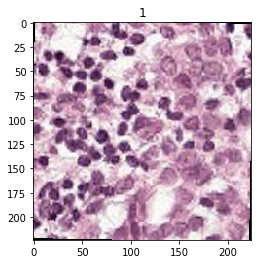

In [246]:
# plot some random training images with their ground truth labels
i = random.choice(range(len(images)))
img = images[i].clone()
img = unnormalize(img)
plt.imshow(img.permute(1, 2, 0))
plt.title(labels[i].item())
plt.show()

In [245]:
mean = torch.as_tensor([0.485, 0.456, 0.406])
std = torch.as_tensor([0.229, 0.224, 0.225])
#return (img * std) + mean
#return img.mul_(std).add_(mean)
labels[i].item()

1

In [52]:
mean, std, mean.shape, std.shape

(tensor([0.4850, 0.4560, 0.4060]),
 tensor([0.2290, 0.2240, 0.2250]),
 torch.Size([3]),
 torch.Size([3]))

torch.Size([3, 224, 224])

In [51]:
import pretrainedmodels
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [52]:
model_name='se_resnext50_32x4d'
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

In [53]:
model

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_po

In [78]:
model.layer0.parameters()
model.layer1.parameters()
model.layer2.parameters()
model.layer3.parameters()
model.layer4.parameters()
#list(model.children())[0]#.parameterss()
model.avg_pool

AvgPool2d(kernel_size=7, stride=1, padding=0)

In [71]:
[
    {"params": model.layer0.paramters()},
    {"params": model.layer1.paramters()},
    {"params": model.layer2.paramters()},
    {"params": model.layer3.paramters()},
    {"params": model.layer4.paramters()},
    {"params": model.avg_pool.paramters()},
    {"params": model.last_linear.parameters(), "lr": 3e-5}
], lr=3e-5*0.001,

import torch

In [72]:
blocks = list(model.children())
head = torch.nn.Sequential(*list(blocks[0].children())[:-1])
model._modules['layer0'] = head
model._modules['last_linear'] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

In [73]:
head.parameters()
#for block in blocks:
#    print(block)
#    print('*'*100)

<generator object Module.parameters at 0x7f931037b750>

In [84]:
#blocks[0] = head

In [85]:
#blocks[-1] = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

In [94]:
#model = torch.nn.Sequential(*blocks)

In [104]:
#model._modules

OrderedDict([('layer0', Sequential(
                (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (relu1): ReLU(inplace)
                (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
              )), ('layer1', Sequential(
                (0): SEResNetBottleneck(
                  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (bn3): BatchNorm2d(256, eps=

In [16]:
#img = torch.Tensor(1, 3, 224, 224)#.to('cuda')
img = torch.Tensor(1, 3, 112, 112)

In [17]:
out = model(img)

print(out)

tensor([[0.1972]], grad_fn=<AddmmBackward>)


In [19]:
# x = None
# for param in model.children():
    
#     print(param)
#     if x is None:
#         x = param(img)
#     else:
#         x = param(x)
#     print(x.shape)

In [14]:
summary(model, input_size=(3, 112, 112))
#summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]           8,192
       BatchNorm2d-5          [-1, 128, 56, 56]             256
              ReLU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           4,608
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]          32,768
      BatchNorm2d-11          [-1, 256, 56, 56]             512
           Conv2d-12          [-1, 256, 56, 56]          16,384
      BatchNorm2d-13          [-1, 256, 56, 56]             512
AdaptiveAvgPool2d-14            [-1, 25

In [69]:
 
from albumentations import *

In [38]:
train_aug = Compose([
    Resize(224, 224),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    Flip(p=0.5),
    OneOf([CLAHE(clip_limit=2), IAASharpen(), IAAEmboss(), RandomBrightnessContrast(), JpegCompression(), Blur(), GaussNoise() ], p=0.5), 
    HueSaturationValue(p=0.5), 
    ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5),
    Normalize(p=1)
])
val_aug = Compose([
    Normalize(p=1)
])


In [30]:
ShiftScaleRotate?

In [32]:
Normalize?

In [40]:
train_aug?

##### AUC ROC

In [1]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]


In [6]:
testy.shape, probs.shape

((500,), (500,))

In [8]:
fpr, tpr, thresholds

(array([0.        , 0.05426357, 0.21705426, 0.40697674, 1.        ]),
 array([0.        , 0.56198347, 0.88429752, 0.97520661, 1.        ]),
 array([2.        , 1.        , 0.66666667, 0.33333333, 0.        ]))

AUC: 0.895


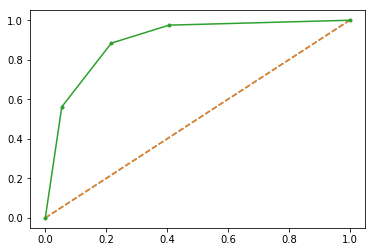

In [9]:
# calculate AUC
auc = roc_auc_score(testy, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(testy, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()